<a href="https://colab.research.google.com/github/kakureru/ISIT/blob/main/Tic_Tac_Toe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd 
import pprint,random

from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import SGD

# Game Engine
Для простоты программа всегда играет с 1, а противник с 0
*   2: пустая ячейка
*   0: О
*   1: X


In [3]:
class tic_tac_toe_game(object):
    def __init__(self):
        self.board=np.full((3,3),2)

    # Имитация жребия
    def toss(self):
        turn=np.random.randint(0,2,size=1)
        if turn.mean()==0:
            self.turn_monitor=0
        elif turn.mean()==1:
            self.turn_monitor=1
        return self.turn_monitor

    # Ход. После совершения хода значение turn_monitor переключается на следующего игрока
    def move(self,player,coord):
        if self.board[coord]!=2 or self.game_status()!="In Progress" or self.turn_monitor!=player:
            raise ValueError("Invalid move")
        self.board[coord]=player
        self.turn_monitor=1-player
        return self.game_status(),self.board

    # Проверка текущего статуса игры: выиграл, ничья или в процессе
    def game_status(self):
        # проверка по строкам
        for i in range(self.board.shape[0]):
            if 2 not in self.board[i,:] and len(set(self.board[i,:]))==1:
                return "Won"
        # проверка по столбцам
        for j in range(self.board.shape[1]):
            if 2 not in self.board[:,j] and len(set(self.board[:,j]))==1:
                return "Won"
        # проверка по диагоналям
        if 2 not in np.diag(self.board) and len(set(np.diag(self.board)))==1:
            return "Won"
        if 2 not in np.diag(np.fliplr(self.board)) and len(set(np.diag(np.fliplr(self.board))))==1:
            return "Won"
        # проверка на ничью
        if not 2 in self.board:
            return "Drawn"
        else:
            return "In Progress"

# Генератор возможных ходов
Получаем набор всех возможных ходов и итоговых состояний доски

In [4]:
def legal_moves_generator(current_board_state,turn_monitor):
    legal_moves_dict={}
    for i in range(current_board_state.shape[0]):
        for j in range(current_board_state.shape[1]):
            if current_board_state[i,j]==2:
                board_state_copy=current_board_state.copy()
                board_state_copy[i,j]=turn_monitor
                legal_moves_dict[(i,j)]=board_state_copy.flatten()
    return legal_moves_dict

# Модель нейронной сети

Модель сопоставляет состояния доски с оценками. Веса нейронной сети инициализируются случайным образом.

In [5]:
model = Sequential()
model.add(Dense(18, input_dim=9,kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(9, kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,kernel_initializer='normal'))

learning_rate = 0.001
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum,nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                180       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
 dropout_1 (Dropout)         (None, 9)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# Выбор хода
Получаем все возможные следующие состояния доски и используем модель для их оценки. Состояние доски, которому присвоен наивысший балл, выбирается в качестве хода

In [6]:
def move_selector(model,current_board_state,turn_monitor):
    tracker={}
    legal_moves_dict=legal_moves_generator(current_board_state,turn_monitor)
    for legal_move_coord in legal_moves_dict:
        score=model.predict(legal_moves_dict[legal_move_coord].reshape(1,9))
        tracker[legal_move_coord]=score
    selected_move=max(tracker, key=tracker.get)
    new_board_state=legal_moves_dict[selected_move]
    score=tracker[selected_move]
    return selected_move,new_board_state,score

# Оппонент
У оппонента есть два режима. Легкий режим помогает программе исследовать пространство крестиков-ноликов. Сложный режим помогает программе научиться играть с реальным противником.

**Легкий режим:**

- Получить все возможные ходы
- Выбрать ход наугад

**Сложный режим:**

- Получить все возможные ходы
- Если какой-либо ход принесет победу, сделать этот ход
- В противном случае, если какой-либо ход мешает оппоненту выиграть, когда он находится на расстоянии одного хода от победы, выбрать этот ход
- В противном случае, если какой-либо ход приводит к строке / диагонали / столбцу с двумя 0 и без 1 (отметка программы), выбрать этот ход
- Если ни одно из вышеперечисленных условий не существует, выбрать ход наугад

Каждая игра проводится в одном из двух режимов, который выбирается случайным образом.



In [7]:
# Проверяем есть ли выигрышные координаты 

# По строкам
def row_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        #check for a win along rows
        for i in range(current_board_state_copy.shape[0]):
            if 2 not in current_board_state_copy[i,:] and len(set(current_board_state_copy[i,:]))==1:
                selected_move=legal_move_coord
                return selected_move

# По столбцам       
def column_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        for j in range(current_board_state_copy.shape[1]):
                    if 2 not in current_board_state_copy[:,j] and len(set(current_board_state_copy[:,j]))==1:
                        selected_move=legal_move_coord
                        return selected_move

# По первой диагонали    
def diag1_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 2 not in np.diag(current_board_state_copy) and len(set(np.diag(current_board_state_copy)))==1:
            selected_move=legal_move_coord
            return selected_move

# По второй диагонали  
def diag2_winning_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 2 not in np.diag(np.fliplr(current_board_state_copy)) and len(set(np.diag(np.fliplr(current_board_state_copy))))==1:
            selected_move=legal_move_coord
            return selected_move
        
# Проверяем можем ли помешать противнику выиграть 

# По строкам 
def row_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        for i in range(current_board_state_copy.shape[0]):
            if 2 not in current_board_state_copy[i,:] and (current_board_state_copy[i,:]==1).sum()==2:
                if not (2 not in current_board_state[i,:] and (current_board_state[i,:]==1).sum()==2):
                    selected_move=legal_move_coord
                    return selected_move

# По столбцам       
def column_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        
        for j in range(current_board_state_copy.shape[1]):
                    if 2 not in current_board_state_copy[:,j] and (current_board_state_copy[:,j]==1).sum()==2:
                        if not (2 not in current_board_state[:,j] and (current_board_state[:,j]==1).sum()==2):
                            selected_move=legal_move_coord
                            return selected_move

# По первой диагонали
def diag1_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor    
        if 2 not in np.diag(current_board_state_copy) and (np.diag(current_board_state_copy)==1).sum()==2:
                if not (2 not in np.diag(current_board_state) and (np.diag(current_board_state)==1).sum()==2):
                    selected_move=legal_move_coord
                    return selected_move

# По второй диагонали      
def diag2_block_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 2 not in np.diag(np.fliplr(current_board_state_copy)) and (np.diag(np.fliplr(current_board_state_copy))==1).sum()==2:
            if not (2 not in np.diag(np.fliplr(current_board_state)) and (np.diag(np.fliplr(current_board_state))==1).sum()==2):
                selected_move=legal_move_coord
                return selected_move

# Проверяем можем ли сделать два 0 и ни одной 1 

# По строкам
def row_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        
        for i in range(current_board_state_copy.shape[0]):
            if 1 not in current_board_state_copy[i,:] and (current_board_state_copy[i,:]==0).sum()==2:
                if not (1 not in current_board_state[i,:] and (current_board_state[i,:]==0).sum()==2):
                    selected_move=legal_move_coord
                    return selected_move
            
# По столбцам            
def column_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        
        for j in range(current_board_state_copy.shape[1]):
                    if 1 not in current_board_state_copy[:,j] and (current_board_state_copy[:,j]==0).sum()==2:
                        if not (1 not in current_board_state[:,j] and (current_board_state[:,j]==0).sum()==2):
                            selected_move=legal_move_coord
                            return selected_move

# По первой диагонали
def diag1_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 1 not in np.diag(current_board_state_copy) and (np.diag(current_board_state_copy)==0).sum()==2:
            if not (1 not in np.diag(current_board_state) and (np.diag(current_board_state)==0).sum()==2):
                selected_move=legal_move_coord
                return selected_move

# По второй диагонали         
def diag2_second_move_check(current_board_state,legal_moves_dict,turn_monitor):
    legal_move_coords =  list(legal_moves_dict.keys())
    random.shuffle(legal_move_coords)
    for legal_move_coord in legal_move_coords:
        current_board_state_copy=current_board_state.copy()
        current_board_state_copy[legal_move_coord]=turn_monitor
        if 1 not in np.diag(np.fliplr(current_board_state_copy)) and (np.diag(np.fliplr(current_board_state_copy))==0).sum()==2:
            if not (1 not in np.diag(np.fliplr(current_board_state)) and (np.diag(np.fliplr(current_board_state))==0).sum()==2):
                selected_move=legal_move_coord
                return selected_move
    
# Выбираем ход    
def opponent_move_selector(current_board_state,turn_monitor,mode):
    legal_moves_dict=legal_moves_generator(current_board_state,turn_monitor)
    
    winning_move_checks=[row_winning_move_check,column_winning_move_check,diag1_winning_move_check,diag2_winning_move_check]
    block_move_checks=[row_block_move_check,column_block_move_check,diag1_block_move_check,diag2_block_move_check]
    second_move_checks=[row_second_move_check,column_second_move_check,diag1_second_move_check,diag2_second_move_check]

    if mode=="Hard":
        random.shuffle(winning_move_checks)
        random.shuffle(block_move_checks)
        random.shuffle(second_move_checks)        
        
        for fn in winning_move_checks:
            if fn(current_board_state,legal_moves_dict,turn_monitor):
                return fn(current_board_state,legal_moves_dict,turn_monitor)
            
        for fn in block_move_checks:
            if fn(current_board_state,legal_moves_dict,turn_monitor):
                return fn(current_board_state,legal_moves_dict,turn_monitor)
            
        for fn in second_move_checks:
            if fn(current_board_state,legal_moves_dict,turn_monitor):
                return fn(current_board_state,legal_moves_dict,turn_monitor)
            
        selected_move=random.choice(list(legal_moves_dict.keys()))
        return selected_move
    
    elif mode=="Easy":
        legal_moves_dict=legal_moves_generator(current_board_state,turn_monitor)
        selected_move=random.choice(list(legal_moves_dict.keys()))
        return selected_move

# Тренировка
Сначала веса модели назначаются случайным образом

После завершения игры результаты корректируются следующим образом:
- Если игра была выиграна программой, присвоить итоговому состоянию доски счет 1
- Присвоить -1 в случае проигрыша 
- 0 в случае ничьей
- Обновить веса модели

In [8]:
def train(model,mode,print_progress=False):
    # начинаем игру
    if print_progress==True:
        print("___________________________________________________________________")
        print("Starting a new game")
    game=tic_tac_toe_game()
    game.toss()
    scores_list=[]
    corrected_scores_list=[]
    new_board_states_list=[]
    
    while(1):
        if game.game_status()=="In Progress" and game.turn_monitor==1:
            # Если ход программы, выибраем возможные ходы
            selected_move,new_board_state,score=move_selector(model,game.board,game.turn_monitor)
            scores_list.append(score[0][0])
            new_board_states_list.append(new_board_state)
            # Делаем ход
            game_status,board=game.move(game.turn_monitor,selected_move)
            if print_progress==True:
                print("Program's Move")
                print(board)
                print("\n")
        elif game.game_status()=="In Progress" and game.turn_monitor==0:
            selected_move=opponent_move_selector(game.board,game.turn_monitor,mode=mode)
        
            # Делаем ход
            game_status,board=game.move(game.turn_monitor,selected_move)
            if print_progress==True:
                print("Opponent's Move")
                print(board)
                print("\n")
        else:
            break

    
    # Корректируем оценки
    new_board_states_list=tuple(new_board_states_list)
    new_board_states_list=np.vstack(new_board_states_list)
    if game_status=="Won" and (1-game.turn_monitor)==1: 
        corrected_scores_list=shift(scores_list,-1,cval=1.0)
        result="Won"
    if game_status=="Won" and (1-game.turn_monitor)!=1:
        corrected_scores_list=shift(scores_list,-1,cval=-1.0)
        result="Lost"
    if game_status=="Drawn":
        corrected_scores_list=shift(scores_list,-1,cval=0.0)
        result="Drawn"
    if print_progress==True:
        print("Program has ",result)
        print("\n Correcting the Scores and Updating the model weights:")
        print("___________________________________________________________________\n")
        
    x=new_board_states_list
    y=corrected_scores_list
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    # перемешиваем x и y
    x,y=unison_shuffled_copies(x,y)
    x=x.reshape(-1,9) 
    
    # обновляем веса модели
    model.fit(x,y,epochs=1,batch_size=1,verbose=0)
    return model,y,result

# Тренировочная игра

In [9]:
updated_model,y,result=train(model,mode="Hard",print_progress=True)

___________________________________________________________________
Starting a new game
Opponent's Move
[[2 2 2]
 [2 2 2]
 [2 2 0]]


1/1 [==============================] - 0s 66ms/step
Program's Move
[[2 2 2]
 [2 2 2]
 [2 1 0]]


Opponent's Move
[[2 2 2]
 [2 2 0]
 [2 1 0]]


1/1 [==============================] - 0s 43ms/step
Program's Move
[[1 2 2]
 [2 2 0]
 [2 1 0]]


Opponent's Move
[[1 2 0]
 [2 2 0]
 [2 1 0]]


Program has  Lost

 Correcting the Scores and Updating the model weights:
___________________________________________________________________



# Тренировка на большом кол-ве игр

In [ ]:
game_counter=1
data_for_graph=pd.DataFrame()

mode_list=["Easy","Hard"]

while(game_counter<=1000):
    mode_selected=np.random.choice(mode_list, 1, p=[0.5,0.5])
    model,y,result=train(model,mode=mode_selected[0],print_progress=False)
    data_for_graph=data_for_graph.append({"game_counter":game_counter,"result":result},ignore_index=True)
    if game_counter % 10 == 0:
        print("Game#: ",game_counter)
        print("Mode: ",mode_selected[0])
    game_counter+=1

Отображение количества побед, ничьих и поражений в зависимости от количества сыгранных игр

Text(0.5, 1.0, 'Distribution of Results Vs Count of Games Played')

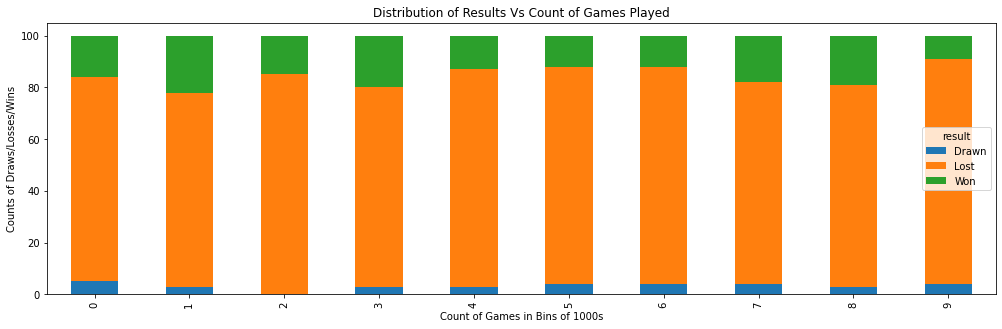

In [15]:
bins = np.arange(1, game_counter/100) * 100
data_for_graph['game_counter_bins'] = np.digitize(data_for_graph["game_counter"], bins, right=True)
counts = data_for_graph.groupby(['game_counter_bins', 'result']).game_counter.count().unstack()
ax=counts.plot(kind='bar', stacked=True,figsize=(17,5))
ax.set_xlabel("Count of Games in Bins of 1000s")
ax.set_ylabel("Counts of Draws/Losses/Wins")
ax.set_title('Distribution of Results Vs Count of Games Played')

In [16]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'